# Configurations

In [1]:
!rm -rf BAD
!git clone https://github.com/Allliance/BAD

from BAD import *

Cloning into 'BAD'...
remote: Enumerating objects: 2371, done.
remote: Counting objects: 100% (377/377), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 2371 (delta 246), reused 318 (delta 210), pack-reused 1994 (from 1)
Receiving objects: 100% (2371/2371), 359.81 KiB | 12.41 MiB/s, done.
Resolving deltas: 100% (1442/1442), done.


2025-01-28 22:44:19.855100: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-28 22:44:19.855243: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-28 22:44:19.986431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
sample_num = None
ARCH_SPLIT = True
rnd = 1
attack_in = False
DEBUG = True

# If EPS > 0, then EPS is fixed
# If EPS = 0, then no attack is performed
# if EPS = None, then epsilon search starts
EPS = None

imagenet_root = mixup_root = '/kaggle/input/tinyimagenet/train_set/train_set/train_set'

source_dataset = 'trojai'

augs = ['cutpaste', 'elastic', 'distort', 'jigsaw', 'gridmask', 'random_erasing']#, 'rot']

K_AUGS = 2

out_dataset = [
    ['jigsaw'],
   #  ['cutpaste', 'cutpaste', 'cutpaste', 'gridmask'],
   # ['cutpaste', 'distort', 'elastic', 'distort', 'jigsaw'],
   # ['elastic', 'cutpaste', 'distort', 'elastic', 'random_erasing'],
   # ['distort', 'elastic', 'cutpaste', 'distort',],
]

# Create all possible

def creat_comb(available, current_augs, k, rep=False):
    global out_dataset

    if k == 0:
        out_dataset.append(current_augs.copy())
        return
    for i, aug in enumerate(available):
        current_augs.append(aug)
        creat_comb(available[:i] + available[i+1:], current_augs, k-1, rep)
        current_augs.pop()

out_dataset = []
creat_comb(augs, [], K_AUGS)

print(out_dataset)
# target_archs = ['squeezenetv1_1', 'squeezenetv1_0', 'shufflenet1_0',
#                 'shufflenet1_5', 'shufflenet2_0', 'googlenet']
# To include all models, set target_arch = None
target_archs = None

attack_norm = 'linf'
if attack_norm == 'linf':
    from BAD.attacks.ood.pgdlinf import PGD as Attack
elif attack_norm == 'l2':
    from BAD.attacks.ood.pgdl2 import PGD as Attack
else:
    raise NotImplementedError("Not a valid norm")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
%load_ext autoreload
%autoreload 2

[['cutpaste', 'elastic'], ['cutpaste', 'distort'], ['cutpaste', 'jigsaw'], ['cutpaste', 'gridmask'], ['cutpaste', 'random_erasing'], ['elastic', 'cutpaste'], ['elastic', 'distort'], ['elastic', 'jigsaw'], ['elastic', 'gridmask'], ['elastic', 'random_erasing'], ['distort', 'cutpaste'], ['distort', 'elastic'], ['distort', 'jigsaw'], ['distort', 'gridmask'], ['distort', 'random_erasing'], ['jigsaw', 'cutpaste'], ['jigsaw', 'elastic'], ['jigsaw', 'distort'], ['jigsaw', 'gridmask'], ['jigsaw', 'random_erasing'], ['gridmask', 'cutpaste'], ['gridmask', 'elastic'], ['gridmask', 'distort'], ['gridmask', 'jigsaw'], ['gridmask', 'random_erasing'], ['random_erasing', 'cutpaste'], ['random_erasing', 'elastic'], ['random_erasing', 'distort'], ['random_erasing', 'jigsaw'], ['random_erasing', 'gridmask']]
Using device: cuda:0


# Preparations

In [2]:
from BAD.trojai.model_dataset import TrojAIDataset as ModelDataset
from BAD.constants import TROJAI_ROOT_DICT

models_root = TROJAI_ROOT_DICT[rnd]['train']['folders'] + TROJAI_ROOT_DICT[rnd]['test']['folders']
models_meta = TROJAI_ROOT_DICT[rnd]['train']['metadata']

# train_root += test_root # here is the key!
# print(train_root)
def prepare_dataset(dataset):
    if ARCH_SPLIT:
        return split_dataset_by_arch(dataset)
    else:
        return {'all_archs': dataset}

def get_length(dataset):
    return sum([len(x) for _, x in dataset.items()])

modelset = prepare_dataset(ModelDataset(models_root, rnd=rnd, model_loader=load_model,
                            custom_arch=None, data_csv=models_meta))

def filter_dataset(dataset):
    return {arch: models for arch, models in dataset.items() if arch in target_archs}

if target_archs:
    modelset = filter_dataset(modelset)

print("Length of modelset", get_length(modelset))

Error while loading models of directory: /kaggle/input/trojai-r1-test/models Error: [Errno 2] No such file or directory: '/kaggle/input/trojai-r1-test/models'
Skipping this directory
Length of modelset 919


In [3]:
all_archs = list(modelset.keys())
print("All groups:")
print(all_archs)

All groups:
['densenet121', 'resnet50', 'inceptionv3']


In [4]:
def param_count(model):
    return sum([p.numel() for p in model.parameters()])

params_count = {}
for arch in all_archs:
    model = modelset[arch][0][0]
    if model is None:
        continue

    params_count[arch] = param_count(model)

all_archs = sorted(all_archs, key=lambda arch: params_count[arch])

for arch in all_archs:
    print(f"{arch}: {params_count[arch] / 1e6}")

Loading a densenet121
Loading a resnet50
Loading a inceptionv3
densenet121: 6.958981
resnet50: 23.518277
inceptionv3: 24.357354


In [5]:
# arch_dict = {arch:{0:0, 1:0} for arch in all_archs}
# for model_data in train_modelset['all_archs'].model_data:
#     arch_dict[model_data['arch']][model_data['label']] += 1

In [6]:
# for arch in arch_dict:
#     print(arch, "Clean:", arch_dict[arch][1], "Poisoned:", arch_dict[arch][0])

## Sanity Checks

In [7]:
def get_sample_model():
    rand_arch = random.sample(list(modelset.keys()), 1)[0]
    rand_dataset = modelset[rand_arch]
    sample_model, _ = rand_dataset[random.randint(0, len(rand_dataset) - 1)]
    return sample_model

In [8]:
sample_model = get_sample_model()
sanity_testloader = get_sanityloader_trojai(sample_model)
print("Accuracy on example data:", evaluate(sample_model, sanity_testloader, device,
                                            metric='acc', attack=None, progress=True))

Loading a densenet121
Loading a dataset with 5 classes


100%|██████████| 16/16 [00:11<00:00,  1.40batch/s]

Accuracy on example data: 0.998


## CLS Loader

In [9]:
from torch.utils.data import Subset

def get_dataloader(model, verbose=False, only_ood=True):
    dataloader = get_oodloader_trojai(model,
                                      out_dataset,
                                      only_ood=only_ood,
                                      imagenet_root=imagenet_root,
                                      sample_num=sample_num,
                                      # debug=True,
                                      dummy_params = {'size': 224},
                                      verbose=verbose)
    if verbose:
        print("Size of dataset:", len(dataloader.dataset))
    return dataloader

next(iter(get_dataloader(get_sample_model(), verbose=True)))
pass

Loading a densenet121
Loading a dataset with 5 classes
Size of dataset: 500


In [10]:
def get_msp(model, data):
    logits = model(data)
    probs = torch.softmax(logits, dim=1)
    scores, _ = torch.max(probs, dim=1)
    return scores

def mean_id_score(model,
                   dataloader,
                   device=None):

    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    id_scores = []

    for data, targets in dataloader:
        data = data.to(device)
        # display(data)
        id_scores += get_msp(model, data).detach().cpu().numpy().tolist()

        torch.cuda.empty_cache()
        gc.collect()

    id_scores = np.asarray(id_scores)

    return np.mean(id_scores)

# sample_model = get_sample_model()
sample_model, _ = modelset['densenet121'][0]
print("Mean ID Score for OOD Dataset:", mean_id_score(sample_model, get_dataloader(sample_model, verbose=True)))
del sample_model

Loading a densenet121
Loading a dataset with 5 classes
Size of dataset: 500
Mean ID Score for OOD Dataset: 0.8917347528338432


Loading a inceptionv3
Loading a dataset with 5 classes
Size of dataset: 1000


<Figure size 640x480 with 0 Axes>

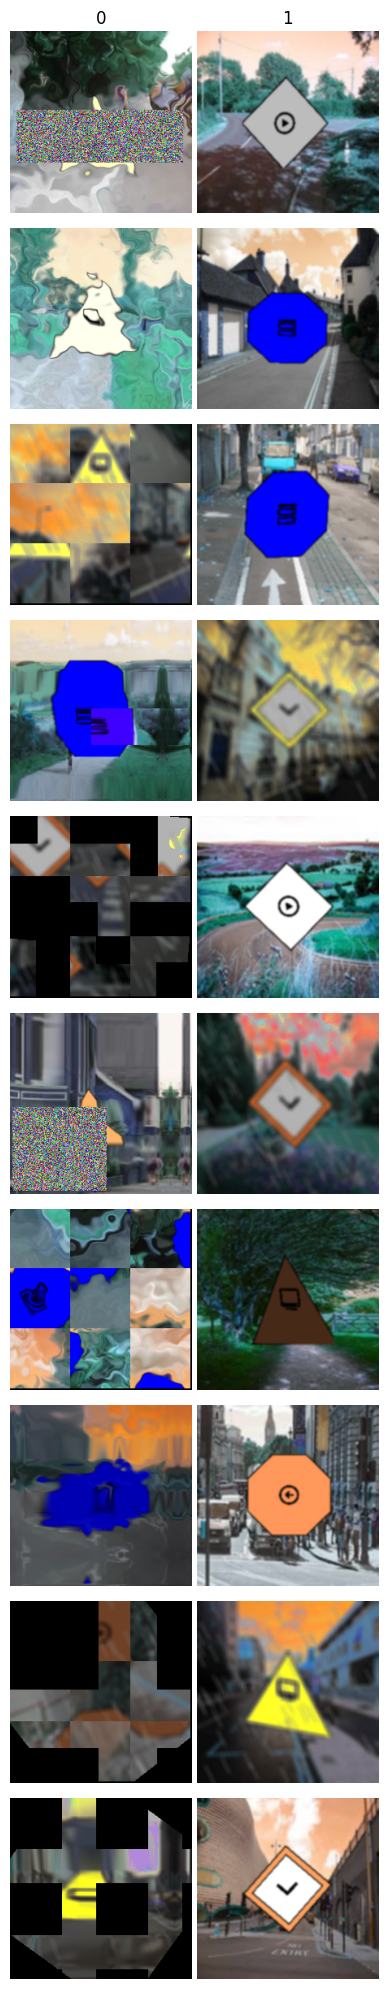

<Figure size 640x480 with 0 Axes>

In [11]:
visualize_samples(get_dataloader(get_sample_model(), verbose=True, only_ood=False), 10)

In [12]:
clear_memory()

# Experiments

In [13]:
import time
import logging
from collections import OrderedDict
from collections.abc import Iterable

import torch
from torch.utils.data import DataLoader, TensorDataset


def wrapper_method(func):
    def wrapper_func(self, *args, **kwargs):
        result = func(self, *args, **kwargs)
        for atk in self.__dict__.get('_attacks').values():
            eval("atk."+func.__name__+"(*args, **kwargs)")
        return result
    return wrapper_func


class Attack(object):
    r"""
    Base class for all attacks.

    .. note::
        It automatically set device to the device where given model is.
        It basically changes training mode to eval during attack process.
        To change this, please see `set_model_training_mode`.
    """

    def __init__(self, name, model, cost_fn=None):
        r"""
        Initializes internal attack state.

        Arguments:
            name (str): name of attack.
            model (torch.nn.Module): model to attack.
        """

        self.attack = name
        self.cost_fn = cost_fn
        self._attacks = OrderedDict()

        self.set_model(model)
        self.device = next(model.parameters()).device

        # Controls attack mode.
        self.attack_mode = 'default'
        self.supported_mode = ['default']
        self.targeted = False
        self._target_map_function = None

        # Controls when normalization is used.
        self.normalization_used = {}
        self._normalization_applied = False
        self._set_auto_normalization_used(model)

        # Controls model mode during attack.
        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, inputs, labels=None, *args, **kwargs):
        r"""
        It defines the computation performed at every call.
        Should be overridden by all subclasses.
        """
        raise NotImplementedError

    def _check_inputs(self, images):
        tol = 1e-4
        if self._normalization_applied:
            images = self.inverse_normalize(images)
        if torch.max(images) > 1+tol or torch.min(images) < 0-tol:
            raise ValueError('Input must have a range [0, 1] (max: {}, min: {})'.format(
                torch.max(images), torch.min(images)))
        return images

    def _check_outputs(self, images):
        if self._normalization_applied:
            images = self.normalize(images)
        return images

    @wrapper_method
    def set_model(self, model):
        self.model = model
        self.model_name = model.__class__.__name__

    def get_logits(self, inputs, labels=None, *args, **kwargs):
        if self._normalization_applied:
            inputs = self.normalize(inputs)
        logits = self.model(inputs)
        return logits

    @wrapper_method
    def _set_normalization_applied(self, flag):
        self._normalization_applied = flag

    @wrapper_method
    def set_device(self, device):
        self.device = device

    @wrapper_method
    def _set_auto_normalization_used(self, model):
        if model.__class__.__name__ == 'RobModel':
            mean = getattr(model, 'mean', None)
            std = getattr(model, 'std', None)
            if (mean is not None) and (std is not None):
                if isinstance(mean, torch.Tensor):
                    mean = mean.cpu().numpy()
                if isinstance(std, torch.Tensor):
                    std = std.cpu().numpy()
                if (mean != 0).all() or (std != 1).all():
                    self.set_normalization_used(mean, std)
    #                 logging.info("Normalization automatically loaded from `model.mean` and `model.std`.")

    @wrapper_method
    def set_normalization_used(self, mean, std):
        n_channels = len(mean)
        mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
        std = torch.tensor(std).reshape(1, n_channels, 1, 1)
        self.normalization_used['mean'] = mean
        self.normalization_used['std'] = std
        self._normalization_applied = True

    def normalize(self, inputs):
        mean = self.normalization_used['mean'].to(inputs.device)
        std = self.normalization_used['std'].to(inputs.device)
        return (inputs - mean) / std

    def inverse_normalize(self, inputs):
        mean = self.normalization_used['mean'].to(inputs.device)
        std = self.normalization_used['std'].to(inputs.device)
        return inputs*std + mean

    def get_mode(self):
        r"""
        Get attack mode.

        """
        return self.attack_mode

    @wrapper_method
    def set_mode_default(self):
        r"""
        Set attack mode as default mode.

        """
        self.attack_mode = 'default'
        self.targeted = False
        print("Attack mode is changed to 'default.'")

    @wrapper_method
    def _set_mode_targeted(self, mode, quiet):
        if "targeted" not in self.supported_mode:
            raise ValueError("Targeted mode is not supported.")
        self.targeted = True
        self.attack_mode = mode
        if not quiet:
            print("Attack mode is changed to '%s'." % mode)

    @wrapper_method
    def set_mode_targeted_by_function(self, target_map_function, quiet=False):
        r"""
        Set attack mode as targeted.

        Arguments:
            target_map_function (function): Label mapping function.
                e.g. lambda inputs, labels:(labels+1)%10.
                None for using input labels as targeted labels. (Default)

        """
        self._set_mode_targeted('targeted(custom)', quiet)
        self._target_map_function = target_map_function

    @wrapper_method
    def set_mode_targeted_random(self, quiet=False):
        r"""
        Set attack mode as targeted with random labels.

        Arguments:
            num_classses (str): number of classes.

        """
        self._set_mode_targeted('targeted(random)', quiet)
        self._target_map_function = self.get_random_target_label

    @wrapper_method
    def set_mode_targeted_least_likely(self, kth_min=1, quiet=False):
        r"""
        Set attack mode as targeted with least likely labels.

        Arguments:
            kth_min (str): label with the k-th smallest probability used as target labels. (Default: 1)

        """
        self._set_mode_targeted('targeted(least-likely)', quiet)
        assert (kth_min > 0)
        self._kth_min = kth_min
        self._target_map_function = self.get_least_likely_label

    @wrapper_method
    def set_mode_targeted_by_label(self, quiet=False):
        r"""
        Set attack mode as targeted.

        .. note::
            Use user-supplied labels as target labels.
        """
        self._set_mode_targeted('targeted(label)', quiet)
        self._target_map_function = 'function is a string'

    @wrapper_method
    def set_model_training_mode(self, model_training=False, batchnorm_training=False, dropout_training=False):
        r"""
        Set training mode during attack process.

        Arguments:
            model_training (bool): True for using training mode for the entire model during attack process.
            batchnorm_training (bool): True for using training mode for batchnorms during attack process.
            dropout_training (bool): True for using training mode for dropouts during attack process.

        .. note::
            For RNN-based models, we cannot calculate gradients with eval mode.
            Thus, it should be changed to the training mode during the attack.
        """
        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    @wrapper_method
    def _change_model_mode(self, given_training):
        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if 'BatchNorm' in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if 'Dropout' in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

    @wrapper_method
    def _recover_model_mode(self, given_training):
        if given_training:
            self.model.train()

    def save(self, data_loader, save_path=None, verbose=True, return_verbose=False,
             save_predictions=False, save_clean_inputs=False, save_type='float'):
        r"""
        Save adversarial inputs as torch.tensor from given torch.utils.data.DataLoader.

        Arguments:
            save_path (str): save_path.
            data_loader (torch.utils.data.DataLoader): data loader.
            verbose (bool): True for displaying detailed information. (Default: True)
            return_verbose (bool): True for returning detailed information. (Default: False)
            save_predictions (bool): True for saving predicted labels (Default: False)
            save_clean_inputs (bool): True for saving clean inputs (Default: False)

        """
        if save_path is not None:
            adv_input_list = []
            label_list = []
            if save_predictions:
                pred_list = []
            if save_clean_inputs:
                input_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)
        given_training = self.model.training

        for step, (inputs, labels) in enumerate(data_loader):
            start = time.time()
            adv_inputs = self.__call__(inputs, labels)
            batch_size = len(inputs)

            if verbose or return_verbose:
                with torch.no_grad():
                    outputs = self.get_output_with_eval_nograd(adv_inputs)

                    # Calculate robust accuracy
                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = (pred == labels.to(self.device))
                    correct += right_idx.sum()
                    rob_acc = 100 * float(correct) / total

                    # Calculate l2 distance
                    delta = (adv_inputs - inputs.to(self.device)).view(batch_size, -1)  # nopep8
                    l2_distance.append(torch.norm(delta[~right_idx], p=2, dim=1))  # nopep8
                    l2 = torch.cat(l2_distance).mean().item()

                    # Calculate time computation
                    progress = (step+1)/total_batch*100
                    end = time.time()
                    elapsed_time = end-start

                    if verbose:
                        self._save_print(progress, rob_acc, l2, elapsed_time, end='\r')  # nopep8

            if save_path is not None:
                adv_input_list.append(adv_inputs.detach().cpu())
                label_list.append(labels.detach().cpu())

                adv_input_list_cat = torch.cat(adv_input_list, 0)
                label_list_cat = torch.cat(label_list, 0)

                save_dict = {'adv_inputs': adv_input_list_cat, 'labels': label_list_cat}  # nopep8

                if save_predictions:
                    pred_list.append(pred.detach().cpu())
                    pred_list_cat = torch.cat(pred_list, 0)
                    save_dict['preds'] = pred_list_cat

                if save_clean_inputs:
                    input_list.append(inputs.detach().cpu())
                    input_list_cat = torch.cat(input_list, 0)
                    save_dict['clean_inputs'] = input_list_cat

                if self.normalization_used is not None:
                    save_dict['adv_inputs'] = self.inverse_normalize(save_dict['adv_inputs'])  # nopep8
                    if save_clean_inputs:
                        save_dict['clean_inputs'] = self.inverse_normalize(save_dict['clean_inputs'])  # nopep8

                if save_type == 'int':
                    save_dict['adv_inputs'] = self.to_type(save_dict['adv_inputs'], 'int')  # nopep8
                    if save_clean_inputs:
                        save_dict['clean_inputs'] = self.to_type(save_dict['clean_inputs'], 'int')  # nopep8

                save_dict['save_type'] = save_type
                torch.save(save_dict, save_path)

        # To avoid erasing the printed information.
        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end='\n')

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    @staticmethod
    def to_type(inputs, type):
        r"""
        Return inputs as int if float is given.
        """
        if type == 'int':
            if isinstance(inputs, torch.FloatTensor) or isinstance(inputs, torch.cuda.FloatTensor):
                return (inputs*255).type(torch.uint8)
        elif type == 'float':
            if isinstance(inputs, torch.ByteTensor) or isinstance(inputs, torch.cuda.ByteTensor):
                return inputs.float()/255
        else:
            raise ValueError(
                type + " is not a valid type. [Options: float, int]")
        return inputs

    @staticmethod
    def _save_print(progress, rob_acc, l2, elapsed_time, end):
        print('- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t'
              % (progress, rob_acc, l2, elapsed_time), end=end)

    @staticmethod
    def load(load_path, batch_size=128, shuffle=False, normalize=None,
             load_predictions=False, load_clean_inputs=False):
        save_dict = torch.load(load_path)
        keys = ['adv_inputs', 'labels']

        if load_predictions:
            keys.append('preds')
        if load_clean_inputs:
            keys.append('clean_inputs')

        if save_dict['save_type'] == 'int':
            save_dict['adv_inputs'] = save_dict['adv_inputs'].float()/255
            if load_clean_inputs:
                save_dict['clean_inputs'] = save_dict['clean_inputs'].float() / 255  # nopep8

        if normalize is not None:
            n_channels = len(normalize['mean'])
            mean = torch.tensor(normalize['mean']).reshape(1, n_channels, 1, 1)
            std = torch.tensor(normalize['std']).reshape(1, n_channels, 1, 1)
            save_dict['adv_inputs'] = (save_dict['adv_inputs'] - mean) / std
            if load_clean_inputs:
                save_dict['clean_inputs'] = (save_dict['clean_inputs'] - mean) / std  # nopep8

        adv_data = TensorDataset(*[save_dict[key] for key in keys])
        adv_loader = DataLoader(
            adv_data, batch_size=batch_size, shuffle=shuffle)
        print("Data is loaded in the following order: [%s]" % (", ".join(keys)))  # nopep8
        return adv_loader

    @torch.no_grad()
    def get_output_with_eval_nograd(self, inputs):
        given_training = self.model.training
        if given_training:
            self.model.eval()
        outputs = self.get_logits(inputs)
        if given_training:
            self.model.train()
        return outputs

    def get_target_label(self, inputs, labels=None):
        r"""
        Function for changing the attack mode.
        Return input labels.
        """
        if self._target_map_function is None:
            raise ValueError(
                'target_map_function is not initialized by set_mode_targeted.')
        if self.attack_mode == 'targeted(label)':
            target_labels = labels
        else:
            target_labels = self._target_map_function(inputs, labels)
        return target_labels

    @torch.no_grad()
    def get_least_likely_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @torch.no_grad()
    def get_random_target_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l)*torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def __call__(self, images, labels=None, *args, **kwargs):
        given_training = self.model.training
        self._change_model_mode(given_training)
        images = self._check_inputs(images)
        adv_images = self.forward(images, labels, *args, **kwargs)
        adv_images = self._check_outputs(adv_images)
        self._recover_model_mode(given_training)
        return adv_images

    def __repr__(self):
        info = self.__dict__.copy()

        del_keys = ['model', 'attack', 'supported_mode']

        for key in info.keys():
            if key[0] == "_":
                del_keys.append(key)

        for key in del_keys:
            del info[key]

        info['attack_mode'] = self.attack_mode
        info['normalization_used'] = True if len(self.normalization_used) > 0 else False  # nopep8

        return self.attack + "(" + ', '.join('{}={}'.format(key, val) for key, val in info.items()) + ")"

    def __setattr__(self, name, value):
        object.__setattr__(self, name, value)

        attacks = self.__dict__.get('_attacks')

        # Get all items in iterable items.
        def get_all_values(items, stack=[]):
            if (items not in stack):
                stack.append(items)
                if isinstance(items, list) or isinstance(items, dict):
                    if isinstance(items, dict):
                        items = (list(items.keys())+list(items.values()))
                    for item in items:
                        yield from get_all_values(item, stack)
                else:
                    if isinstance(items, Attack):
                        yield items
            else:
                if isinstance(items, Attack):
                    yield items

        for num, value in enumerate(get_all_values(value)):
            attacks[name+"."+str(num)] = value
            for subname, subvalue in value.__dict__.get('_attacks').items():
                attacks[name+"."+subname] = subvalue

In [14]:
import torch
import torch.nn as nn

class PGD(Attack):
    r"""
    PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]
    Distance Measure : Linf
    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)
        random_start (bool): using random initialization of delta. (Default: True)
    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.
    Examples::
        >>> attack = torchattacks.PGD(model, eps=8/255, alpha=1/255, steps=10, random_start=True)
        >>> adv_images = attack(images, labels)
    """

    def __init__(self, model, target_class=None, eps=8/255, alpha=2/255, steps=10, random_start=True):
        super().__init__("PGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)

        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + \
                torch.empty_like(adv_images).uniform_(-self.eps, self.eps)
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()


        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)
            probs = torch.softmax(outputs, dim=1)

            cost = torch.sum(torch.max(probs, dim=1).values)

            # Update adversarial images
            grad = torch.autograd.grad(cost, adv_images,
                                       retain_graph=False, create_graph=False)[0]

            adv_images = adv_images.detach() + self.alpha*grad.sign()
            delta = torch.clamp(adv_images - images,
                                min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

In [15]:
# def final_score_function(modelset, eps, **kwargs):
#     return get_aucs(modelset, eps, get_dataloader, score=score, attack_class=Attack, attack_in=attack_in, **kwargs)

In [16]:
def get_msp(model, data):
    logits = model(data)
    probs = torch.softmax(logits, dim=1)
    scores, _ = torch.max(probs, dim=1)
    return scores

def mean_id_score_diff(model,
                       dataloader,
                       device=None,
                       verbose=False,
                       eps=1/255):

    if device is None:
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    attack_eps = eps
    attack_steps = 10
    attack_alpha = 2.5 * attack_eps / attack_steps

    attack = None
    if attack_eps > 0:
        attack = PGD(model, eps=attack_eps, steps=attack_steps, alpha=attack_alpha)
    before_attack_scores = []
    after_attack_scores = []

    for data, targets in dataloader:

        # before attack
        data = data.to(device)

        before_attack = get_msp(model, data)

        before_attack_scores += before_attack.detach().cpu().numpy().tolist()

        # after attack
        if attack:
            adv_data = attack(data, targets)

            after_attack = get_msp(model, adv_data)

            after_attack_scores += after_attack.detach().cpu().numpy().tolist()

        torch.cuda.empty_cache()
        gc.collect()

    before_attack_scores = np.asarray(before_attack_scores)
    after_attack_scores = np.asarray(after_attack_scores)


    before_attack_mean_scores = np.mean(before_attack_scores)
    after_attack_mean_scores = 0
    if len(after_attack_scores):
        after_attack_mean_scores = np.mean(after_attack_scores)

    if verbose:
        print("Before:", before_attack_mean_scores)
        print("After:", after_attack_mean_scores)

    return after_attack_mean_scores - before_attack_mean_scores

In [17]:
torch.cuda.empty_cache()

In [18]:
import gc
gc.collect()

0

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

def draw_dists(a, b):
    # sample

    # a = [0.1, 0.2, 0.5, 0.7, 0.3, 0.8, 0.6]
    # b = [0.2, 0.4, 0.1, 0.5, 0.9, 0.7, 0.2]

    plt.figure(figsize=(10, 6))

    # Plot the distributions using histograms
    sns.histplot(a, bins=20, color='blue', label='Clean Models Scores', kde=True, stat="density", alpha=0.5)
    sns.histplot(b, bins=20, color='orange', label='Trojaned Models scores', kde=True, stat="density", alpha=0.5)

    # Add labels and legend
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.title('Distribution of Values in Lists A and B')
    plt.legend()

    # Display the plot
    plt.show()

# draw_dists(good_scores, bad_scores)

Working on densenet121 model 1/100
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.8946723012328148
After: 0.999132249712944
0 0.10445994848012918
Working on densenet121 model 2/100
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.8561560092568398
After: 0.997946477651596
1 0.14179046839475629
Current AUC: 1.0
Working on densenet121 model 3/100
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.8828342736959457
After: 0.9992196801900863
0 0.11638540649414064
Current AUC: 1.0
Working on densenet121 model 4/100
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.8624281688928604
After: 0.9883737423419953
1 0.12594557344913482
Current AUC: 1.0
Working on densenet121 model 5/100
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.8963058591485024
After: 0.9938598383665085
0 0.09755397921800613
Current AUC: 1.0
Working on densenet121 model 6/100
Loading a densenet121
Loading a dataset with 5 classes
Before: 0.825162614

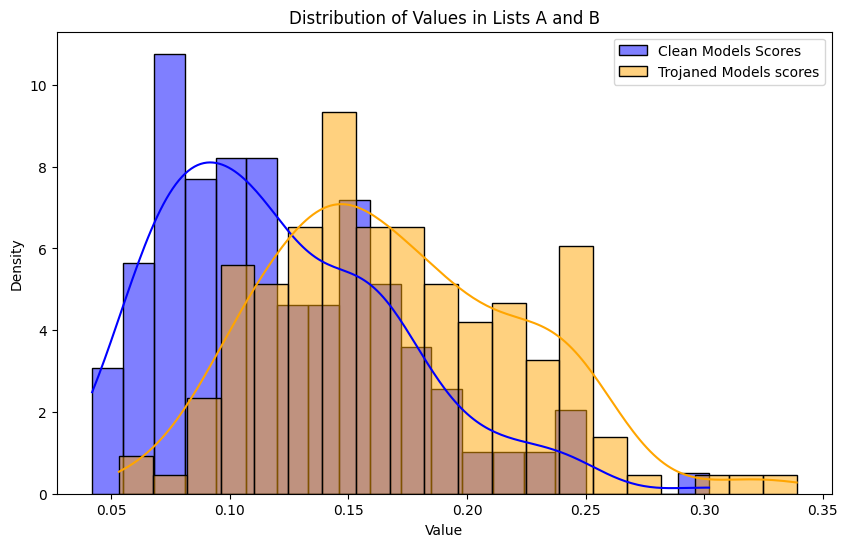

Total number of failed models: 0
Average weighted auroc across all groups: 0.7598789989118607
Average normal auroc across all groups: 0.7554222222222222


In [20]:
from tqdm import tqdm
import random

clear_memory()

Aucs = {}
# Accs = {}

no_failed = 0

bad_scores = []
good_scores = []

LIMIT = 100

all_labels = []
all_scores = []

for arch in all_archs:

    try:
        arch_modelset = modelset[arch]
        labels = []
        scores = []
        cnt = min(len(arch_modelset), LIMIT)
        for i in range(cnt):
            print(f"Working on {arch} model {i+1}/{cnt}")
            # just for test
            # score = random.uniform(0, 1)

            # if label == 0:
            #     good_scores.append(score)
            # else:
            #     bad_scores.append(score)

            # del model
            # continue
            try:
                model, label = arch_modelset[i]


                dataloader = get_dataloader(model)

                score = mean_id_score_diff(model, dataloader, verbose=True, eps=2/255)
                del model


                if label == 0:
                    good_scores.append(score)
                else:
                    bad_scores.append(score)

                labels.append(label)
                scores.append(score)
                print(label, score)
                if 0 in labels and 1 in labels:
                    print(f"Current AUC: {roc_auc_score(labels, scores)}")
            except Exception as e:
                print("An error occured while loading a", arch, "model")
                print("Error:", str(e))
                no_failed += 1

                continue
        all_labels += labels
        all_scores += scores
        final_auc = roc_auc_score(labels, scores)
        print(f"Final AUROC on test set for group {arch}: {final_auc}")
        Aucs[arch] = final_auc
    except Exception as e:
        print("An error on saving results for ", arch, "models")
        print("Error:", str(e))

draw_dists(good_scores, bad_scores)

print("Total number of failed models:", no_failed)

# weighted_mean_acc = 0
weighted_mean_auc = 0
all_cnt = 0
for arch in Aucs.keys():
    cnt = len(modelset[arch])
    # weighted_mean_acc += cnt * Accs[arch]
    weighted_mean_auc += cnt * Aucs[arch]
    all_cnt += cnt
print("Average weighted auroc across all groups:", weighted_mean_auc / all_cnt)
print("Average normal auroc across all groups:", roc_auc_score(all_labels, all_scores))